In [126]:
import torch

In [127]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [128]:
device

device(type='cuda')

In [129]:
import yaml
from types import SimpleNamespace

# load config
config_path = "/export/home/workspace/dreambooth/diffusers/configs/zerobooth.yaml"
config = yaml.load(open(config_path, "r"), Loader=yaml.FullLoader)
config = SimpleNamespace(**config)

In [130]:
from modeling_zerobooth import ZeroBooth

model = ZeroBooth(config=config.model)

Creating model
Resizing position embedding grid-size from %s to %s (16, 16) (28, 28)
_IncompatibleKeys(missing_keys=[], unexpected_keys=['visual.proj', 'visual.ln_post.weight', 'visual.ln_post.bias', 'visual.transformer.resblocks.23.attn.in_proj_weight', 'visual.transformer.resblocks.23.attn.in_proj_bias', 'visual.transformer.resblocks.23.attn.out_proj.weight', 'visual.transformer.resblocks.23.attn.out_proj.bias', 'visual.transformer.resblocks.23.ln_1.weight', 'visual.transformer.resblocks.23.ln_1.bias', 'visual.transformer.resblocks.23.mlp.c_fc.weight', 'visual.transformer.resblocks.23.mlp.c_fc.bias', 'visual.transformer.resblocks.23.mlp.c_proj.weight', 'visual.transformer.resblocks.23.mlp.c_proj.bias', 'visual.transformer.resblocks.23.ln_2.weight', 'visual.transformer.resblocks.23.ln_2.bias'])
freeze class_embedding
freeze positional_embedding
freeze conv1.weight
freeze ln_pre.weight
freeze ln_pre.bias
freeze transformer.resblocks.0.attn.in_proj_weight
freeze transformer.resblocks.0.

In [131]:
# load_from = "/export/home/workspace/dreambooth/diffusers/output/pretrain-20221211-bs=3-nq=8-prenorm-norm_clip=all_tune=4/65000"
# load_from = "/export/home/workspace/dreambooth/diffusers/output/pretrain-20221225-unet-only/40000"
# load_from = "/export/home/workspace/dreambooth/diffusers/output/pretrain-20221225-unet-only/70000"
# load_from = "/export/home/workspace/dreambooth/diffusers/output/pretrain-20221227-unet-textenc-coco/40000"
load_from = "/export/home/workspace/dreambooth/diffusers/output/pretrain-20221227-unet-textenc-coco/40000"
# load_from = "/export/home/workspace/dreambooth/diffusers/output/pretrain-20221227-unet-only-coco/50000"
model.load_checkpoint(load_from)
model.to(device)
model.eval()


ZeroBooth(
  (blip): BLIP(
    (visual_encoder): VisionTransformer(
      (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
            )
            (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (drop_path): Identity()
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
 

In [132]:
from PIL import Image

# load image
def load_image(path):
    img = Image.open(path).convert("RGB")
    return img

In [133]:
def display_img(img):
    w, h = img.size
    f = 368 / max(w, h)

    display(img.resize((int(w * f), int(h * f))))

a dog head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses,head-shot wearing sunglasses


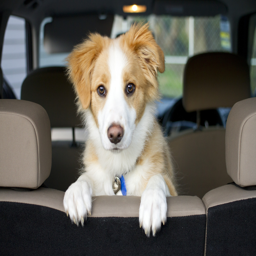

In [176]:

# subject = "car, vehicle, sports car"
subject = "random"
# subject = "car"
# prompt = "a dog at the great canyon, surrounded by desert mountains at sunset on mars, planet mars, moab, utah, a tilt shift photo by frederic church, trending on unsplash, hudson river school, 3 5 mm photo, photo taken with provia, national geographic photo"
# prompt = "a dog at the mount fuji, peach blossoms on the clouds, brilliant peaks, dense fog, early morning, by by yoneyama mai, trending on artstation" 
# prompt = "a dog at the mount fuji, at the mount fuji, at the mount fuji, at the mount fuji, at the mount fuji, highly-detailed, highly-detailed, highly-detailed, highly-detailed,"
# prompt = "a dog wearing a space suit, wearing a space suit, wearing a space suit, wearing a nice sapce suit, wearing a cool space suit"
# prompt = "a dog head-shot wearing sunglasses, head-shot wearing sunglasses, head-shot wearing sunglasses, wearing sunglasses, wearing sunglasses, wearing sunglasses, wearing sunglasses, wearing sunglasses, wearing sunglasses, wearing sunglasses,"

# caption = "a dog"
# caption = "a avan gogh painting of a dog"
# caption = "a sleeping dog"
# caption = "a car"
caption = "a dog"
# caption = "a koala"
subprompt = "head-shot wearing sunglasses"
# subprompt = "head-shot wearing space suit"
# subprompt = "in the outer space"
# subprompt = "painting"
# subprompt = "surreal background, plants and flowers, mexican art, naive art, by frida kahlo" # [BAD]
# subprompt = "headshot wearing sunglasses" # [OOD]
# subprompt = "on sunny meadow"
# subprompt = "cosmic painting, galaxy, space, earth"
# subprompt = "swimming in the ocean"
# subprompt = "in Paris, eiffle tower, france, national geographic photo, "
# subprompt = "at yellow stone national park, national geographic photo, "
# subprompt = "wearing sunglasses"
# subprompt = "at the grand canyon, national geographic photo, "
# subprompt = "on a painting, style of van gogh"
# subprompt = "at the grand canyon, national geographic photo, "
# subprompt = "wearing sunglasses, headshot, vaporwave, highly reflective, mexican art"
# subprompt = "wearing nice cool vaporwave sunglasses, at the grand canyon"
# subprompt = "at the grand canyon, river, at sunset"
# subprompt = "at mountain fuji, cherry blossoms on the clouds, brilliant peaks, sunny, early morning, by by yoneyama mai, trending on artstation"
# subprompt = "at the grand canyon, surrounded by desert mountains at sunset on mars, planet mars, moab, utah, a tilt shift photo by frederic church, trending on unsplash, hudson river school, 3 5 mm photo, photo taken with provia, national geographic photo"
# subprompt = "in the style of van gogh"
# subprompt = "3d low poly, low-resolution"
# subprompt = "superman suit"
# subprompt = "twelve apostles australia, a poppy field with a icy moutain in the background and a blue sky this 4k hd image is trending on artstation, featured on behance, well-rendered, extra crisp"
prompt = caption + " " + ",".join([subprompt] * 20)

print(prompt)
# image_path = "/export/home/workspace/dreambooth/diffusers/data/NationalGeographic_2731043_4x3.webp"
# image_path = "/export/home/workspace/dreambooth/diffusers/data/hat-dog.png"
# image_path = "/export/home/workspace/dreambooth/diffusers/data/00sl-pets-superJumbo.webp"
# image_path = "/export/home/workspace/dreambooth/diffusers/data/dog-harness-1598455194.jpeg"
# image_path = "/export/home/workspace/dreambooth/diffusers/data/gold-retriever-in-red-car.jpeg"
image_path = "/export/home/workspace/dreambooth/diffusers/data/shutterstock_517026226.jpeg"
# image_path = "/export/home/workspace/dreambooth/diffusers/data/cat-dog.webp"
# image_path = "/export/home/workspace/dreambooth/diffusers/data/Bernese-mountain-dog-grass.webp"
# image_path = "/export/home/workspace/dreambooth/diffusers/data/sphnix-cat.jpg"
# image_path = "/export/home/workspace/dreambooth/diffusers/data/Pembroke-Welsh-Corgi-standing-outdoors-in-the-fall.jpeg"
# image_path = "/export/home/workspace/dreambooth/diffusers/data/miller-motor.png"
# image_path = "/export/home/workspace/dreambooth/diffusers/data/istockphoto-1311993425-170667a.jpeg"
image = load_image(image_path)

display(image.resize((256, 256)))

In [177]:
config.image_size

392

In [178]:
from train_zerobooth import create_transforms

# create transforms
transforms = create_transforms(config)

inp_tsfm = transforms["inp_image_transform"]
txt_tsfm = transforms["text_transform"]

In [179]:
samples = {
    "input_images": inp_tsfm(image).unsqueeze(0).to(device),
    "class_names": [txt_tsfm(subject)],
    "prompt": [txt_tsfm(prompt)],
    "ctx_begin_pos": [2]
}

100%|██████████| 250/250 [00:34<00:00,  7.29it/s]


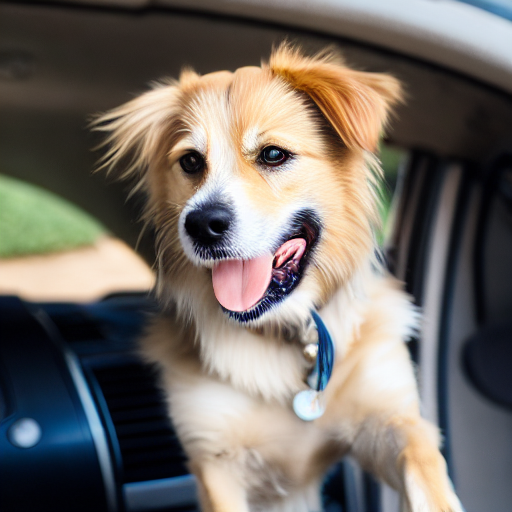

100%|██████████| 250/250 [00:34<00:00,  7.30it/s]


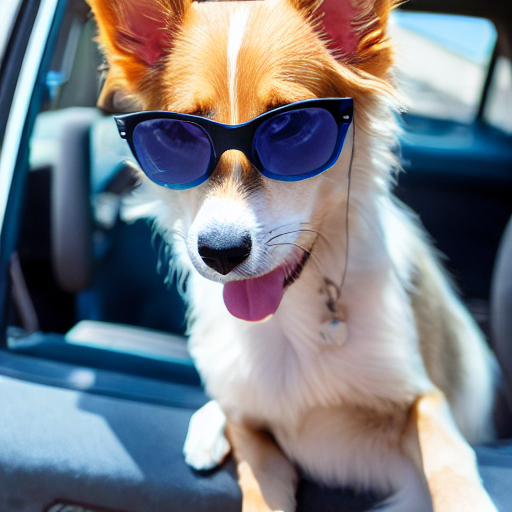

100%|██████████| 250/250 [00:34<00:00,  7.32it/s]


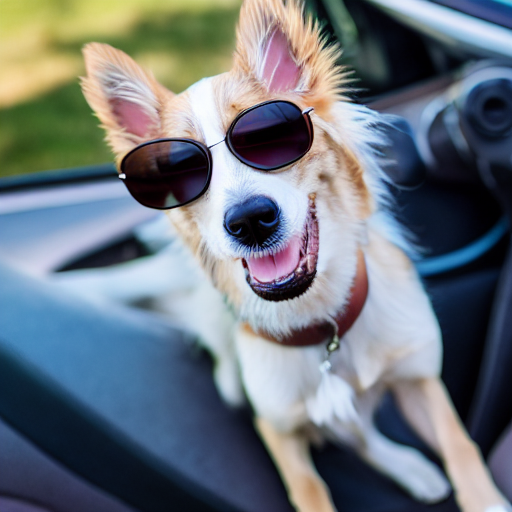

100%|██████████| 250/250 [00:34<00:00,  7.33it/s]


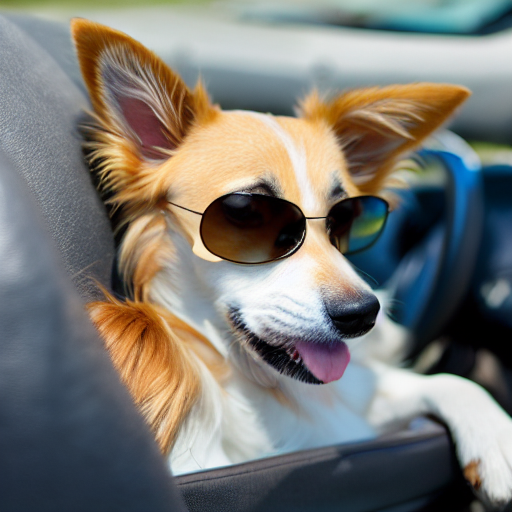

100%|██████████| 250/250 [00:34<00:00,  7.33it/s]


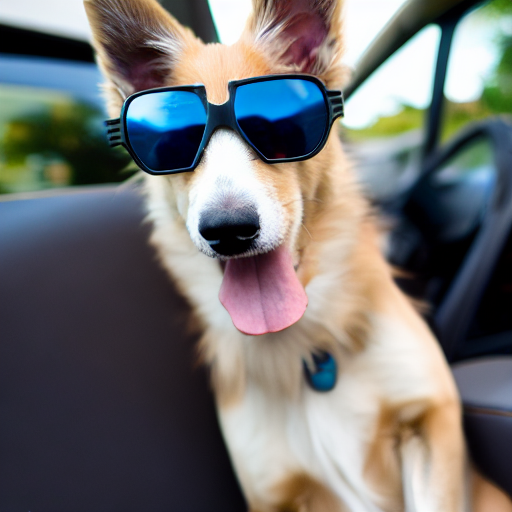

In [182]:
for i in range(5):
    # output = model.generate(samples,
    #     seed=387602220011,
    #     guidance_scale=7.5,
    #     disable_bg_model=True,
    #     v_condition=False
    # )
    output = model.generate_dual(samples,
        seed=387600409,
        guidance_scale=7.5,
        theta=4
    )
    # output = model.generate(samples, seed=387658222, guidance_scale=7.5)

    display(output[0])